<a href="https://colab.research.google.com/github/tqsyed/confNorm/blob/main/CE_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 36342935.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
import math
import torch.optim as optim

f = nn.Sigmoid()
# it days LNC but the hisaab is  apprently CE


def LNC_loss(output, target):
       #if (sum(output) - output[target]) == 0:
         #print((sum(output) - output[target]))
         #return 0
       return (output[target] / (sum(output)))# - output[target])

class new_loss(nn.CrossEntropyLoss):
  def forward(self, input, target):
        val = 0
        for i in range(0,len(input)):
          val +=  LNC_loss(f(input[i]), target[i])
        # print("Cross Entropy Value")
        # print(F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction))
        # print("Ratio Value")
        # print(val)
        if(math.isnan(val)):
          print(val)
          return F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction)
        #print(F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction))
        return F.cross_entropy(input, target, weight=self.weight, ignore_index=self.ignore_index, reduction=self.reduction) # - (0.01 *  val)
        #return val



criterion = new_loss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # new '23 cuda thing
        inputs, labels = inputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)


        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = outputs.type(torch.cuda.FloatTensor)
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.254
[1,  4000] loss: 1.934
[1,  6000] loss: 1.754
[1,  8000] loss: 1.637
[1, 10000] loss: 1.533
[1, 12000] loss: 1.503
Finished Training


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# google.colab.patches import cv2_imshow
# print images
# cv2_imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

GroundTruth:    cat  ship  ship plane


In [ ]:

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        inputs, outputs, labels, images = inputs.type(torch.cuda.FloatTensor), outputs.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor), images.type(torch.cuda.FloatTensor)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 47 %


In [ ]:

confidences = []
for i in range(0,10):
  confidences.append([])
confidences

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))




with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
        outputs = net(images)
        labels = labels.int()
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            confidences[labels[i]].append(f(outputs[i]))


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))




Accuracy of plane : 38 %
Accuracy of   car : 69 %
Accuracy of  bird : 35 %
Accuracy of   cat : 14 %
Accuracy of  deer : 23 %
Accuracy of   dog : 45 %
Accuracy of  frog : 66 %
Accuracy of horse : 72 %
Accuracy of  ship : 60 %
Accuracy of truck : 49 %


In [ ]:
from sklearn.metrics import confusion_matrix

nb_classes = 10

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')


with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        # for i in range(4):
        #     label = labels[i]
        #     pred = c[i]

        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        lbllist=torch.cat([lbllist,labels.view(-1).cpu()])



# with torch.no_grad():
#     for i, (inputs, classes) in enumerate(dataloaders['val']):
#         inputs = inputs.to(device)
#         classes = classes.to(device)
#         outputs = model_ft(inputs)
#         _, preds = torch.max(outputs, 1)

#         # Append batch prediction results
#         predlist=torch.cat([predlist,preds.view(-1).cpu()])
#         lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[386  65 119   8  22  14  27  68 206  85]
 [  9 698   9  11   8   5  34  24  54 148]
 [ 47  21 355  26  76 166 121 145  22  21]
 [  6  18  92 144  47 264 173 207  14  35]
 [ 21  21 222  19 239  75 144 233  18   8]
 [  4   9 104  52  36 458  70 247   9  11]
 [  2  17  57  34  72  49 662  78   4  25]
 [  8  16  37  22  43  90  31 725   7  21]
 [ 84 111  30   7   9  15  26  29 603  86]
 [ 10 241  13  11   2   9  61  91  65 497]]
[38.6 69.8 35.5 14.4 23.9 45.8 66.2 72.5 60.3 49.7]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(lbllist.numpy(), predlist.numpy()))

              precision    recall  f1-score   support

         0.0       0.67      0.39      0.49      1000
         1.0       0.57      0.70      0.63      1000
         2.0       0.34      0.35      0.35      1000
         3.0       0.43      0.14      0.22      1000
         4.0       0.43      0.24      0.31      1000
         5.0       0.40      0.46      0.43      1000
         6.0       0.49      0.66      0.56      1000
         7.0       0.39      0.72      0.51      1000
         8.0       0.60      0.60      0.60      1000
         9.0       0.53      0.50      0.51      1000

    accuracy                           0.48     10000
   macro avg       0.49      0.48      0.46     10000
weighted avg       0.49      0.48      0.46     10000



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def hist(cno):
  df2 = pd.DataFrame()
  for i in range(0,len(confidences[cno])):
    df2 = df2.append(pd.DataFrame(confidences[cno][i].numpy().reshape(-1, len(confidences[cno][i].numpy()))))


  corr = df2.corr()
  corr.style.background_gradient(cmap='coolwarm')

  arr = []
  for i in range(0,10):
    arr.append(sum(df2.iloc[:,i])/1000)

  plt.bar(np.arange(len(arr)),arr)
  plt.show()

In [ ]:
for i in range(0,10):
  print(i)
  hist(i)

In [ ]:
class correct


<ipython-input-45-79a963f6e5fb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(pd.DataFrame(outputs.cpu()[i]))
<ipython-input-45-79a963f6e5fb>:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(pd.DataFrame(outputs.cpu()[i]))


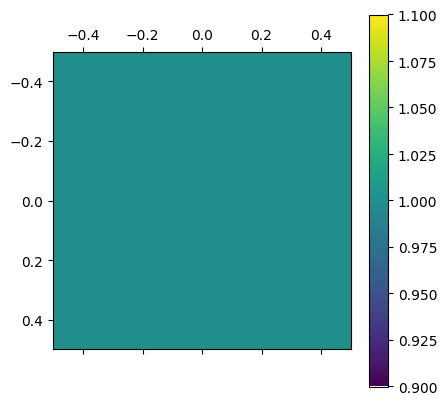

In [ ]:
import pandas as pd
df2 = pd.DataFrame()


for i in range(0,len(outputs)):
  df2 = df2.append(pd.DataFrame(outputs.cpu()[i]))

import matplotlib.pyplot as plt

plt.matshow(df2.corr())
plt.colorbar()
plt.show()

In [ ]:
import collections
mc = []
for i in range(0,10):
  mc.append([])


df2 = pd.DataFrame()
for nu in range(0, 10):
  results = []
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.type(torch.cuda.FloatTensor), labels.type(torch.cuda.FloatTensor)
          outputs = net(images)
          _, predicted = torch.max(outputs, 1)
          c = (predicted == labels).squeeze()
          cp = c.cpu()
          for i in range(4):
              label = labels.cpu()[i]
              class_correct[label.int()] += cp[i].item()
              class_total[label.int()] += 1
              if(label == nu):
                results.append(predicted[i].item())
              #confidences[labels[i]].append(f(outputs[i]))

  print(results)
  mc[nu] = results
  #df2 = df2.append(pd.DataFrame(np.array(list(collections.Counter(results).values())).reshape(-1, len(np.array(list(collections.Counter(results).values()))))))




[8, 0, 2, 7, 8, 6, 9, 8, 2, 7, 0, 0, 6, 8, 2, 9, 9, 9, 8, 9, 8, 2, 0, 9, 0, 7, 1, 8, 0, 2, 9, 9, 9, 8, 0, 0, 2, 7, 2, 8, 8, 8, 6, 0, 1, 0, 7, 8, 7, 6, 0, 8, 8, 0, 9, 1, 0, 6, 8, 4, 0, 9, 1, 8, 0, 8, 8, 8, 1, 0, 8, 2, 6, 1, 0, 5, 2, 4, 8, 0, 8, 1, 0, 9, 0, 0, 0, 0, 7, 2, 8, 8, 7, 4, 4, 0, 8, 8, 0, 8, 0, 5, 2, 1, 0, 0, 0, 0, 4, 0, 4, 8, 7, 1, 0, 0, 0, 0, 2, 0, 1, 5, 8, 9, 0, 8, 0, 0, 0, 8, 1, 2, 8, 8, 0, 8, 2, 9, 8, 0, 0, 0, 0, 2, 8, 0, 0, 1, 8, 9, 2, 9, 1, 8, 0, 7, 0, 0, 2, 7, 0, 1, 0, 2, 0, 2, 9, 0, 0, 0, 8, 2, 9, 9, 0, 0, 0, 2, 7, 0, 0, 9, 3, 0, 0, 8, 6, 5, 8, 0, 8, 0, 0, 0, 9, 2, 8, 8, 1, 8, 2, 2, 2, 5, 7, 1, 8, 0, 7, 0, 0, 0, 7, 7, 8, 2, 9, 4, 0, 7, 5, 0, 9, 0, 9, 1, 1, 0, 2, 0, 2, 8, 8, 1, 0, 0, 0, 8, 1, 8, 0, 7, 0, 9, 8, 2, 0, 0, 0, 7, 2, 1, 6, 9, 0, 2, 9, 2, 0, 7, 0, 2, 8, 2, 9, 7, 7, 7, 0, 2, 8, 9, 0, 2, 0, 0, 2, 0, 0, 0, 0, 7, 0, 0, 0, 2, 9, 0, 8, 0, 8, 8, 0, 7, 0, 8, 8, 0, 8, 7, 0, 0, 2, 2, 0, 0, 7, 2, 0, 8, 0, 9, 8, 8, 2, 9, 2, 8, 8, 6, 1, 6, 0, 7, 0, 0, 0, 7, 0, 2, 1, 0, 0, 

In [ ]:
import numpy as np
df2 = pd.DataFrame()
for i in range(0,10):
  df2 = df2.append(pd.value_counts(np.array(mc[i])).sort_index(), ignore_index = True)



<ipython-input-60-0dfd1e7e13f1>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(pd.value_counts(np.array(mc[i])).sort_index(), ignore_index = True)
<ipython-input-60-0dfd1e7e13f1>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(pd.value_counts(np.array(mc[i])).sort_index(), ignore_index = True)
<ipython-input-60-0dfd1e7e13f1>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(pd.value_counts(np.array(mc[i])).sort_index(), ignore_index = True)
<ipython-input-60-0dfd1e7e13f1>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append(pd.value_counts(np.array(mc[i])).sort_index(), i

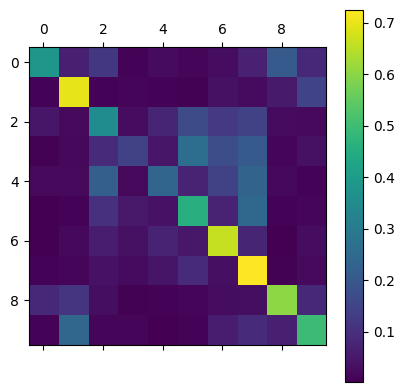

,0,1,2,3,4,5,6,7,8,9
0,0.000386,0.000065,0.000119,0.000008,0.000022,0.000014,0.000027,0.000068,0.000206,0.000085
1,0.000009,0.000698,0.000009,0.000011,0.000008,0.000005,0.000034,0.000024,0.000054,0.000148
2,0.000047,0.000021,0.000355,0.000026,0.000076,0.000166,0.000121,0.000145,0.000022,0.000021
3,0.000006,0.000018,0.000092,0.000144,0.000047,0.000264,0.000173,0.000207,0.000014,0.000035
4,0.000021,0.000021,0.000222,0.000019,0.000239,0.000075,0.000144,0.000233,0.000018,0.000008
5,0.000004,0.000009,0.000104,0.000052,0.000036,0.000458,0.000070,0.000247,0.000009,0.000011
6,0.000002,0.000017,0.000057,0.000034,0.000072,0.000049,0.000662,0.000078,0.000004,0.000025
7,0.000008,0.000016,0.000037,0.000022,0.000043,0.000090,0.000031,0.000725,0.000007,0.000021
8,0.000084,0.000111,0.000030,0.000007,0.000009,0.000015,0.000026,0.000029,0.000603,0.000086
9,0.000010,0.000241,0.000013,0.000011,0.000002,0.000009,0.000061,0.000091,0.000065,0.000497


In [ ]:
import matplotlib.pyplot as plt
df2 = df2/1000
plt.matshow(df2)
plt.colorbar()
plt.show()
df2/1000